# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by Jason

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project, we will use machine learning tools to cluster Toronto and New York neighborhoods in order to recommend the neighborhoods which are the best choices for migrants based on surrounded essential facilities such as school, hospital, and stores etc.

We will be using two datasets for this project: The first dataset toront.csv consists of Toronto’s boroughs, Neighbourhoods and their respective postcodes. The second dataset NewYork.csv consists of NewYork’s city name, districts and subdistrict. Both datasets were scraped from Wikipedia page.

Foursquare API provides access to massive datasets of location data and venues information including address, images, tips, ratings and comments. In this project, we will use Foursquare API and Geopy data to locate nearby venues within 500 meters of each neighbourhood in Toronto and New York.

## Data <a name="data"></a>

### Data Collection
Toronto ad New York neighborhoods' data will be scraped from Wikipedia page and converted into pandas dataframe. 

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import requests

from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import json

from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors

! pip install folium==0.5.0
import folium

print("Libraries imported")

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Libraries imported


In [2]:
# Toronto 
!wget -q -O 'toronto_data.csv' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv
print('Data downloaded!')

df_toronto = pd.read_csv('toronto_data.csv')
df_toronto.head()

# Part 1 Data
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source, 'lxml')

table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['Postal Code'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df_part1=pd.DataFrame(table_contents)
df_part1['Borough']=df_part1['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

# Merge
Toronto_neighborhoods_df = pd.merge(df_part1,
                 df_toronto[['Postal Code','Latitude', 'Longitude']],
                 on='Postal Code')
Toronto_neighborhoods_df.head()

# Replace Postal Code with City Name
Toronto_neighborhoods_df = Toronto_neighborhoods_df.drop(['Postal Code'], axis=1)
Toronto_neighborhoods_df.insert(0, 'City', 'Toronto')
Toronto_neighborhoods_df.head()

Data downloaded!


,City,Borough,Neighborhood,Latitude,Longitude
0,Toronto,North York,Parkwoods,43.753259,-79.329656
1,Toronto,North York,Victoria Village,43.725882,-79.315572
2,Toronto,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,Toronto,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Toronto,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [3]:
# Same for New York
# Download data from external source
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
newyork_neighborhood = newyork_data['features']
# Transform data into a DataFrame
column_names = ['City','Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
newyork_df = pd.DataFrame(columns=column_names)
for data in newyork_neighborhood:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyork_df = newyork_df.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
newyork_df.head()

# Replace City name with New York
newyork_df = newyork_df.drop(['City'], axis=1)
newyork_df.insert(0, 'City', 'New York')
newyork_df.head()

,City,Borough,Neighborhood,Latitude,Longitude
0,New York,Bronx,Wakefield,40.894705,-73.847201
1,New York,Bronx,Co-op City,40.874294,-73.829939
2,New York,Bronx,Eastchester,40.887556,-73.827806
3,New York,Bronx,Fieldston,40.895437,-73.905643
4,New York,Bronx,Riverdale,40.890834,-73.912585


## Methodology

We now have the borough, neighborhood, latitude and longitude data files ready for Toronto and New York

Let's then merge the two city's data into one data frame

In [4]:
df_toronto_newyork =  pd.concat([Toronto_neighborhoods_df, newyork_df])
print('There are total {} neighbourhoods in Toronto and New York.'.format(df_toronto_newyork.shape[0]))
df_toronto_newyork.head()

There are total 409 neighbourhoods in Toronto and New York.


,City,Borough,Neighborhood,Latitude,Longitude
0,Toronto,North York,Parkwoods,43.753259,-79.329656
1,Toronto,North York,Victoria Village,43.725882,-79.315572
2,Toronto,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,Toronto,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Toronto,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


Data Visuliztion

In [5]:
# Define FourSquare User Credentials
CLIENT_ID = 'IYFBVOOC4FUPEP1IKI4ZIKTDVQHM10BBOUHPHD0KFSW3WJBQ' # your Foursquare ID
CLIENT_SECRET = 'HABZNP1ZU5SF0NLFQX15GHIP2XL1PGPK3P2HPWCSNATU1YE5' # your Foursquare Secret
ACCESS_TOKEN = 'Y5ZE2W2GA43XRCWLIZER0EOEEZGSHMGK3OE2IMPGCHUJC5AT' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IYFBVOOC4FUPEP1IKI4ZIKTDVQHM10BBOUHPHD0KFSW3WJBQ
CLIENT_SECRET:HABZNP1ZU5SF0NLFQX15GHIP2XL1PGPK3P2HPWCSNATU1YE5


In [6]:
# Define a funciton that creates a map of different neighbourhoods in the city.
def getMap (cityname,countryname,dataframe):
    address = cityname + ',' + countryname

    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of ' + cityname + ' are {}, {}.'.format(latitude, longitude))
    
    # create map using latitude and longitude values.
    city_map = folium.Map(location=[latitude, longitude], zoom_start=10)

    # set color scheme for the Borough
    borough_name = dataframe['Borough'].unique().tolist()
    colnum = dataframe['Borough'].unique().size
    x = np.arange(colnum)
    ys = [i+x+(i*x)**2 for i in range(colnum)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    for lat, lon, Neighborhood, borough in zip(dataframe['Latitude'], dataframe['Longitude'], dataframe['Neighborhood'], dataframe['Borough']):
        cluster = borough_name.index(borough)
        label = '{}, {}'.format(Neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7).add_to(city_map)  
    return city_map

In [7]:
# Get Toronto's Map
getMap('Toronto','Canada',Toronto_neighborhoods_df)

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [8]:
# Get New York map
getMap('New York', 'United States', newyork_df)

The geograpical coordinate of New York are 40.7127281, -74.0060152.


Use Foursqaure API to get Venues

In [9]:
def getNearbyVenues(cities, boroughs, neighborhoods, latitudes, longitudes, radius=500):
    
    # Define limit of venues to get
    LIMIT = 100
    
    venues_list=[]
    for city, borough, neighborhood, lat, lng in zip(cities, boroughs, neighborhoods, latitudes, longitudes):
        print(neighborhood)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(city, 
            borough, 
            neighborhood, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City',
                  'Borough',          
                  'Neighborhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue',  
                  'Venue Category']
    
    return(nearby_venues)

Call the getNearbyVenues function on each Neighborhood and create a new dataframe called toronto_venues

In [10]:
toronto_venues = getNearbyVenues(Toronto_neighborhoods_df['City'], Toronto_neighborhoods_df['Borough'], 
                                 Toronto_neighborhoods_df['Neighborhood'], Toronto_neighborhoods_df['Latitude'],
                                 Toronto_neighborhoods_df['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

Check the size of DataFrame

In [11]:
print(toronto_venues.shape)
toronto_venues.head()

(2119, 7)


,City,Borough,Neighborhood,Latitude,Longitude,Venue,Venue Category
0,Toronto,North York,Parkwoods,43.753259,-79.329656,KFC,Fast Food Restaurant
1,Toronto,North York,Parkwoods,43.753259,-79.329656,Brookbanks Park,Park
2,Toronto,North York,Parkwoods,43.753259,-79.329656,Variety Store,Food & Drink Shop
3,Toronto,North York,Victoria Village,43.725882,-79.315572,Victoria Village Arena,Hockey Arena
4,Toronto,North York,Victoria Village,43.725882,-79.315572,Portugril,Portuguese Restaurant


Check how many venues were returned for each Neiborhood.

In [12]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))
toronto_venues.groupby('Neighborhood').count()

There are 269 uniques categories.


,City,Borough,Latitude,Longitude,Venue,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
...,...,...,...,...,...,...
Willowdale West,6,6,6,6,6,6
"Willowdale, Newtonbrook",2,2,2,2,2,2
Woburn,4,4,4,4,4,4


Let's do the same for New York city

In [13]:
newyork_venues = getNearbyVenues(newyork_df['City'], newyork_df['Borough'], 
                                 newyork_df['Neighborhood'], newyork_df['Latitude'],
                                 newyork_df['Longitude']
                                )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [14]:
print(newyork_venues.shape)
newyork_venues.head()

(10155, 7)


,City,Borough,Neighborhood,Latitude,Longitude,Venue,Venue Category
0,New York,Bronx,Wakefield,40.894705,-73.847201,Lollipops Gelato,Dessert Shop
1,New York,Bronx,Wakefield,40.894705,-73.847201,Walgreens,Pharmacy
2,New York,Bronx,Wakefield,40.894705,-73.847201,Carvel Ice Cream,Ice Cream Shop
3,New York,Bronx,Wakefield,40.894705,-73.847201,Subway,Sandwich Place
4,New York,Bronx,Wakefield,40.894705,-73.847201,Rite Aid,Pharmacy


Check how many venues are returned in each neighborhood

In [15]:
print('There are {} uniques categories.'.format(len(newyork_venues['Venue Category'].unique())))
newyork_venues.groupby('Neighborhood').count()

There are 434 uniques categories.


,City,Borough,Latitude,Longitude,Venue,Venue Category
Neighborhood,,,,,,
Allerton,27,27,27,27,27,27
Annadale,10,10,10,10,10,10
Arden Heights,6,6,6,6,6,6
Arlington,5,5,5,5,5,5
Arrochar,21,21,21,21,21,21
...,...,...,...,...,...,...
Woodhaven,26,26,26,26,26,26
Woodlawn,29,29,29,29,29,29
Woodrow,15,15,15,15,15,15


For the combined DataFrame

In [16]:
toronto_newyork_venues =  pd.concat([toronto_venues,newyork_venues])
print(toronto_newyork_venues.shape)

toronto_newyork_venues.head()

(12274, 7)


,City,Borough,Neighborhood,Latitude,Longitude,Venue,Venue Category
0,Toronto,North York,Parkwoods,43.753259,-79.329656,KFC,Fast Food Restaurant
1,Toronto,North York,Parkwoods,43.753259,-79.329656,Brookbanks Park,Park
2,Toronto,North York,Parkwoods,43.753259,-79.329656,Variety Store,Food & Drink Shop
3,Toronto,North York,Victoria Village,43.725882,-79.315572,Victoria Village Arena,Hockey Arena
4,Toronto,North York,Victoria Village,43.725882,-79.315572,Portugril,Portuguese Restaurant


In [17]:
# Make all restaurants category into one
toronto_newyork_venues.loc[toronto_newyork_venues['Venue Category'].str.contains('Restaurant', case=False), 'Venue Category'] = 'Restaurant'
print(toronto_newyork_venues.shape)
toronto_newyork_venues.head(10)

(12274, 7)


,City,Borough,Neighborhood,Latitude,Longitude,Venue,Venue Category
0,Toronto,North York,Parkwoods,43.753259,-79.329656,KFC,Restaurant
1,Toronto,North York,Parkwoods,43.753259,-79.329656,Brookbanks Park,Park
2,Toronto,North York,Parkwoods,43.753259,-79.329656,Variety Store,Food & Drink Shop
3,Toronto,North York,Victoria Village,43.725882,-79.315572,Victoria Village Arena,Hockey Arena
4,Toronto,North York,Victoria Village,43.725882,-79.315572,Portugril,Restaurant
5,Toronto,North York,Victoria Village,43.725882,-79.315572,Tim Hortons,Coffee Shop
6,Toronto,North York,Victoria Village,43.725882,-79.315572,Eglinton Ave E & Sloane Ave/Bermondsey Rd,Intersection
7,Toronto,North York,Victoria Village,43.725882,-79.315572,Pizza Nova,Pizza Place
8,Toronto,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Tandem Coffee,Coffee Shop
9,Toronto,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Roselle Desserts,Bakery


Perform onehot encoding

In [18]:
toronto_newyork_onehot = pd.get_dummies(toronto_newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add Neighbourhood column back to dataframe
toronto_newyork_onehot['Neighborhood'] = toronto_newyork_venues['Neighborhood'] 

# move Neighbourhood column to the first column
fixed_columns = [toronto_newyork_onehot.columns[-1]] + list(toronto_newyork_onehot.columns[:-1])
print(toronto_newyork_onehot.shape)
toronto_newyork_onehot.head()

(12274, 372)


,ATM,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Animal Shelter,...,Waste Facility,Waterfront,Weight Loss Center,Well,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Group categories

In [19]:
toronto_newyork_grouped = toronto_newyork_onehot.groupby('Neighborhood').mean().reset_index()
print(toronto_newyork_grouped.shape)
toronto_newyork_grouped.head()

(399, 372)


,Neighborhood,ATM,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Waste Facility,Waterfront,Weight Loss Center,Well,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Allerton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Annadale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Print each Neighbourhood along with the top 5 most common venues.

In [20]:
num_top_venues = 5

for hood in toronto_newyork_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_newyork_grouped[toronto_newyork_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
            venue  freq
0  Breakfast Spot   0.2
1          Lounge   0.2
2    Skating Rink   0.2
3  Clothing Store   0.2
4      Restaurant   0.2


----Alderwood, Long Branch----
                venue  freq
0         Pizza Place  0.29
1         Coffee Shop  0.14
2                 Gym  0.14
3      Sandwich Place  0.14
4  Athletics & Sports  0.14


----Allerton----
           venue  freq
0     Restaurant  0.15
1    Pizza Place  0.11
2            Spa  0.07
3  Deli / Bodega  0.07
4       Pharmacy  0.07


----Annadale----
            venue  freq
0     Pizza Place   0.2
1  Cosmetics Shop   0.1
2        Pharmacy   0.1
3            Food   0.1
4    Dance Studio   0.1


----Arden Heights----
          venue  freq
0      Pharmacy  0.17
1    Playground  0.17
2   Pizza Place  0.17
3   Coffee Shop  0.17
4  Home Service  0.17


----Arlington----
           venue  freq
0   Intersection   0.2
1  Boat or Ferry   0.2
2     Restaurant   0.2
3       Bus Stop   0.2
4  Deli / Bodega   0.2


-

Sort the venues in descending order.

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each Neighbourhood.

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_newyork_venues_sorted = pd.DataFrame(columns=columns)
toronto_newyork_venues_sorted['Neighborhood'] = toronto_newyork_grouped['Neighborhood']

for ind in np.arange(toronto_newyork_grouped.shape[0]):
    toronto_newyork_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_newyork_grouped.iloc[ind, :], num_top_venues)

print(toronto_newyork_venues_sorted.shape)    
toronto_newyork_venues_sorted.head(10)


(399, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Restaurant,Breakfast Spot,Skating Rink,Clothing Store,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Electronics Store
1,"Alderwood, Long Branch",Pizza Place,Pub,Sandwich Place,Athletics & Sports,Coffee Shop,Gym,Costume Shop,Event Service,Dog Run,Donut Shop
2,Allerton,Restaurant,Pizza Place,Pharmacy,Spa,Discount Store,Deli / Bodega,Martial Arts School,Check Cashing Service,Grocery Store,Dessert Shop
3,Annadale,Pizza Place,Bar,Food,Cosmetics Shop,Diner,Pharmacy,Train Station,Restaurant,Dance Studio,Escape Room
4,Arden Heights,Pharmacy,Home Service,Playground,Deli / Bodega,Pizza Place,Coffee Shop,Yoga Studio,Event Service,Donut Shop,Dosa Place
5,Arlington,Boat or Ferry,Intersection,Bus Stop,Deli / Bodega,Restaurant,Yoga Studio,Exhibit,Drugstore,Dry Cleaner,Electronics Store
6,Arrochar,Restaurant,Bagel Shop,Pizza Place,Bus Stop,Deli / Bodega,Sandwich Place,Cosmetics Shop,Food Truck,Outdoors & Recreation,Liquor Store
7,Arverne,Surf Spot,Metro Station,Sandwich Place,Playground,Burrito Place,Café,BBQ Joint,Tiki Bar,Beach,Restaurant
8,Astoria,Restaurant,Bar,Bakery,Hookah Bar,Café,Deli / Bodega,Bubble Tea Shop,Bagel Shop,Dessert Shop,Gym / Fitness Center
9,Astoria Heights,Bowling Alley,Museum,Bakery,Bus Station,Restaurant,Supermarket,Pizza Place,Burger Joint,Food,Hostel


### Use Machine Learning algorithms

We will apply K-Means model to segment and cluster all the neighborhoods in Toronto and Shanghai.
First, we use Elbow Method to determine the value of K.

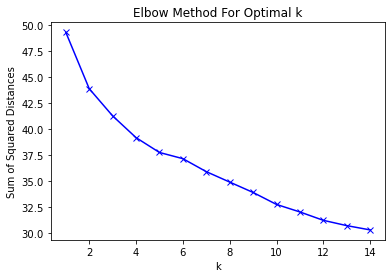

In [23]:
import sklearn
import matplotlib.pyplot as plt

Sum_of_squared_distances = []
K = range(1, 15)
toronto_newyork_grouped_clustering = toronto_newyork_grouped.drop('Neighborhood', 1)

for kvalues in K:
    km = KMeans(n_clusters=kvalues, init='k-means++', n_init=10, max_iter=300, tol=0.0001,  random_state=10).fit(toronto_newyork_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The elbow point of the line chart is determined as the right K for clustering. Here K equals to 4.

In [24]:
# set number of clusters to 4
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_newyork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 3, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 3, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 3, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 3, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,

Create a new dataframe that includes the cluster as well as the top 10 venues for each Neighbourhood in Toronto and New York.

In [42]:
# add clustering labels
toronto_newyork_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

toronto_newyork_merged = df_toronto_newyork

# merge sorted venues with df_toronto_sh to add latitude/longitude for each Neighbourhood
toronto_newyork_merged = toronto_newyork_merged.join(toronto_newyork_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

#Drop the rows that have no data.
toronto_newyork_merged=toronto_newyork_merged.dropna()
toronto_newyork_merged.shape

print(toronto_newyork_merged.shape)
toronto_newyork_merged.head(10)

ValueError: cannot insert Cluster_Labels, already exists

Define a function to visualize the resulting clusters.

In [26]:
def displayClusters(city, country, dataframe):

    address = city + ',' + country

    geolocator = Nominatim(user_agent="Foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    cluster_map = folium.Map(location=[latitude, longitude], zoom_start=10)

    # set color scheme for the Cluster_Labels
    x = np.arange(kclusters)
    ys = [i+x+(i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    for lat, lon, neighborhood, borough, cluster_labels in zip(dataframe['Latitude'], 
                                                                dataframe['Longitude'], 
                                                                dataframe['Neighborhood'], 
                                                                dataframe['Borough'],
                                                                dataframe['Cluster_Labels']):
        cluster = int(cluster_labels)
        label = '{}, {},Cluster {}'.format(neighborhood, borough, cluster)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=0.7).add_to(cluster_map)
    return cluster_map


## Results

Let's check each neighborhood in each cluster

In [27]:
for cluster_num in range(4):
    num_of_nbh = toronto_newyork_merged[toronto_newyork_merged['Cluster_Labels'] == cluster_num].shape[0]
    print('The number of neighborhoods in cluster {} is {}'.format(cluster_num+1, num_of_nbh))

The number of neighborhoods in cluster 1 is 211
The number of neighborhoods in cluster 2 is 180
The number of neighborhoods in cluster 3 is 8
The number of neighborhoods in cluster 4 is 5


Mostly suburb areas where have access to hotels, airports and football stadium.

In [28]:
cluster1 = toronto_newyork_merged.loc[toronto_newyork_merged['Cluster_Labels'] == 0]
print('There are {} neighborhoods in cluster 1'.format(cluster1.shape[0]))
cluster1

There are 211 neighborhoods in cluster 1


,City,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Toronto,North York,Parkwoods,43.753259,-79.329656,0.0,Food & Drink Shop,Park,Restaurant,Event Service,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Electronics Store
1,Toronto,North York,Victoria Village,43.725882,-79.315572,0.0,Coffee Shop,Intersection,Hockey Arena,Pizza Place,Restaurant,Yoga Studio,Donut Shop,Dosa Place,Drugstore,Dry Cleaner
6,Toronto,Scarborough,"Malvern, Rouge",43.806686,-79.194353,0.0,Restaurant,Exhibit,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Electronics Store,Entertainment Service,Escape Room,Event Service
7,Toronto,North York,Don Mills North,43.745906,-79.352188,0.0,Restaurant,Gym,Café,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Electronics Store,Entertainment Service
9,Toronto,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0.0,Restaurant,Coffee Shop,Clothing Store,Sandwich Place,Café,Cosmetics Shop,Hotel,Theater,Movie Theater,Bookstore
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,New York,Queens,Middle Village,40.716415,-73.881143,0.0,Restaurant,Thrift / Vintage Store,Pharmacy,Farmers Market,Bank,Bakery,Sandwich Place,Park,Diner,Dessert Shop
292,New York,Staten Island,Lighthouse Hill,40.576506,-74.137927,0.0,Restaurant,Café,Spa,Trail,Art Museum,Yoga Studio,Donut Shop,Dosa Place,Drugstore,Dry Cleaner
297,New York,Bronx,Bronxdale,40.852723,-73.861726,0.0,Restaurant,Pizza Place,Gym,Department Store,Deli / Bodega,Bank,Supermarket,Performing Arts Venue,Breakfast Spot,Farm
299,New York,Bronx,Kingsbridge Heights,40.870392,-73.901523,0.0,Restaurant,Pizza Place,Bus Station,Check Cashing Service,Grocery Store,Food Truck,Coffee Shop,Park,Deli / Bodega,School


In [29]:
print('Toronto:')
displayClusters('Toronto', 'Canada', cluster1[cluster1['City'] == 'Toronto'])

Toronto:


In [30]:
print('New York:')
displayClusters('New York', 'United States', cluster1[cluster1['City'] == 'New York'])

New York:


Basically are residential areas with parks, grocery stores, pharmacy and restaurants.

In [31]:
cluster2 = toronto_newyork_merged.loc[toronto_newyork_merged['Cluster_Labels'] == 1]
print('There are {} neighborhoods in cluster 2'.format(cluster2.shape[0]))
cluster2

There are 180 neighborhoods in cluster 2


,City,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Toronto,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Coffee Shop,Bakery,Park,Pub,Restaurant,Theater,Breakfast Spot,Café,Distribution Center,Chocolate Shop
3,Toronto,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,Clothing Store,Accessories Store,Furniture / Home Store,Boutique,Restaurant,Miscellaneous Shop,Event Space,Coffee Shop,Drugstore,Dry Cleaner
4,Toronto,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,1.0,Coffee Shop,Restaurant,Sandwich Place,Gym,Distribution Center,Park,Theater,Bar,Yoga Studio,Diner
8,Toronto,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937,1.0,Pizza Place,Gym / Fitness Center,Gastropub,Flea Market,Intersection,Pharmacy,Athletics & Sports,Bank,Donut Shop,Dosa Place
11,Toronto,Etobicoke,"West Deane Park, Princess Gardens, Martin Grov...",43.650943,-79.554724,1.0,Bakery,Yoga Studio,Exhibit,Dosa Place,Drugstore,Dry Cleaner,Electronics Store,Entertainment Service,Escape Room,Event Service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,New York,Bronx,Allerton,40.865788,-73.859319,1.0,Restaurant,Pizza Place,Pharmacy,Spa,Discount Store,Deli / Bodega,Martial Arts School,Check Cashing Service,Grocery Store,Dessert Shop
300,New York,Brooklyn,Erasmus,40.646926,-73.948177,1.0,Restaurant,Yoga Studio,School,Bank,Convenience Store,Donut Shop,Food Truck,Furniture / Home Store,Grocery Store,Gym / Fitness Center
302,New York,Queens,Hammels,40.587338,-73.805530,1.0,Beach,Ice Cream Shop,Deli / Bodega,Dog Run,Gym / Fitness Center,Diner,Bus Stop,Bus Station,Restaurant,Shoe Store
304,New York,Queens,Queensbridge,40.756091,-73.945631,1.0,Hotel,Cocktail Bar,Beer Garden,Scenic Lookout,Sandwich Place,Basketball Court,Baseball Field,Park,Gym / Fitness Center,Restaurant


In [32]:
print('Toronto:')
displayClusters('Toronto', 'Canada', cluster1[cluster1['City'] == 'Toronto'])

Toronto:


In [33]:
print('New York:')
displayClusters('New York', 'United States', cluster1[cluster1['City'] == 'New York'])

New York:


Including neighbourhoods with restaurants and distribution centers.

In [34]:
cluster3 = toronto_newyork_merged.loc[toronto_newyork_merged['Cluster_Labels'] == 2]
print('There are {} neighborhoods in cluster 3'.format(cluster3.shape[0]))
cluster3

There are 8 neighborhoods in cluster 3


,City,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Toronto,York,Caledonia-Fairbanks,43.689026,-79.453512,2.0,Park,Women's Store,Pool,Yoga Studio,Exhibit,Dosa Place,Drugstore,Dry Cleaner,Electronics Store,Entertainment Service
35,Toronto,East York/East Toronto,The Danforth East,43.685347,-79.338106,2.0,Convenience Store,Park,Yoga Studio,Exhibit,Dosa Place,Drugstore,Dry Cleaner,Electronics Store,Entertainment Service,Escape Room
40,Toronto,North York,Downsview East,43.737473,-79.464763,2.0,Park,Airport,Yoga Studio,Exhibit,Dosa Place,Drugstore,Dry Cleaner,Electronics Store,Entertainment Service,Escape Room
52,Toronto,North York,"Willowdale, Newtonbrook",43.789053,-79.408493,2.0,Park,Yoga Studio,Event Space,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Electronics Store,Entertainment Service,Escape Room
64,Toronto,York,Weston,43.706876,-79.518188,2.0,Convenience Store,Yoga Studio,Factory,Dosa Place,Drugstore,Dry Cleaner,Electronics Store,Entertainment Service,Escape Room,Event Service
66,Toronto,North York,York Mills West,43.752758,-79.400049,2.0,Park,Convenience Store,Yoga Studio,Exhibit,Dosa Place,Drugstore,Dry Cleaner,Electronics Store,Entertainment Service,Escape Room
27,New York,Bronx,Clason Point,40.806551,-73.854144,2.0,Park,Playground,Scenic Lookout,Grocery Store,Bus Stop,Restaurant,Boat or Ferry,Convenience Store,Pool,Fish & Chips Shop
203,New York,Staten Island,Todt Hill,40.597069,-74.111329,2.0,Park,Yoga Studio,Event Space,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Electronics Store,Entertainment Service,Escape Room


In [35]:
print('Toronto:')
displayClusters('Toronto', 'Canada', cluster1[cluster1['City'] == 'Toronto'])

Toronto:


In [36]:
print('New York:')
displayClusters('New York', 'United States', cluster1[cluster1['City'] == 'New York'])

New York:


Mostly downtown areas where surrounded by lots of restaurants, cafeteria, bars, convenience stores and different kinds of shops.

In [37]:
cluster4 = toronto_newyork_merged.loc[toronto_newyork_merged['Cluster_Labels'] == 3]
print('There are {} neighborhoods in cluster 4'.format(cluster4.shape[0]))
cluster4

There are 5 neighborhoods in cluster 4


,City,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Toronto,Scarborough,Scarborough Village,43.744734,-79.239476,3.0,Playground,Yoga Studio,Exhibit,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Electronics Store,Entertainment Service,Escape Room
85,Toronto,Scarborough,"Milliken, Agincourt North, Steeles East, L'Amo...",43.815252,-79.284577,3.0,Park,Intersection,Playground,Arts & Crafts Store,Yoga Studio,Event Space,Dosa Place,Drugstore,Dry Cleaner,Electronics Store
29,New York,Bronx,Country Club,40.844246,-73.824099,3.0,Sandwich Place,Athletics & Sports,Playground,Yoga Studio,Event Service,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner
45,New York,Bronx,Edenwald,40.884561,-73.848083,3.0,Grocery Store,Sandwich Place,Playground,Supermarket,Event Service,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner
303,New York,Queens,Bayswater,40.611322,-73.765968,3.0,Playground,Yoga Studio,Exhibit,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Electronics Store,Entertainment Service,Escape Room


In [38]:
print('Toronto:')
displayClusters('Toronto', 'Canada', cluster1[cluster1['City'] == 'Toronto'])

Toronto:


In [39]:
print('New York:')
displayClusters('New York', 'United States', cluster1[cluster1['City'] == 'New York'])

New York:


## Discussion
From the results, we can conclude that for those who prefer to settle down in a residential area where surrounded by parks, grocery stores, pharmacy and restaurants, cluster 2 would be the best choice. While for those who prefer to live in a more crowded area where have access to a variety of venues, cluster 4 would be the best choice.
However, from the results, we notice that the majority of the neighbourhoods in Toronto lie into cluster 2 and 4. This is due to the limitations this research hold. To result in a better clustering, we will need further data such as more detailed venues information in New York. 